### All Code Comparison

In [1]:
import os
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import *
from hamming_channel_47 import HammingChannel47
from ldpc_channel import LdpcChannel
import matplotlib.pyplot as plt
import pickle
from ldpc_bpsk_gaussian_system import LdpcBpskGaussianSystem

#### Hamming

In [2]:
# 1. Escolha um valor de p. Utilize p = 0.5,0.2,0.1,0.05,0.02,0.01,0.005,...

snrs_db = np.arange(0, 10.5, 0.5) 
ps = []
R = 4/7
for snr_db in snrs_db:
    ps.append(Ei_N0_to_p(snr_db, R)) 
    
bit_values = [0, 1]
save_folder = "./bit_error_results"
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
method = "hamming"
for p in ps:
    print(f"p = {p}")
    
    # 2. Gere aleatoriamente cerca de 1 milhão de bits de informação
    # 3. Divida em grupos de K bits. Haverá L grupos
    save_path_original = save_folder + f"/{p}-{method}-bits-original.npy"    

    if not os.path.isfile(save_path_original):  
        random_info_bits = np.array(random.choices(bit_values, weights=[1, 1], k = int(1e6))) 
        k = 4
        original_bits_groups = random_info_bits.reshape(-1, k) 
        with open(save_path_original, "wb") as f:
            np.save(f, original_bits_groups)
    else:
        with open(save_path_original, "rb") as f:
            original_bits_groups = np.load(f)
            
    # 4: Gere as L palavras-código correspondentes a cada um dos grupos do item 3
    # 5: Simule o efeito do canal BSC trocando o valor dos bits das palavras código do item anterior 
    # com probabilidade p para todos os bits de todas as L palavras-código, gerando assim L palavras recebidas.
    # 6: Realize o processo de detecção por síndrome para cada uma das L palavras recebidas.
    # 7: Realize o processo de estimação sobre os bits de informação.
    save_path_decoded = save_folder + f"/{p}-{method}-bits-decoded.npy"

    if not os.path.isfile(save_path_decoded):
        hamming_channel = HammingChannel47(p)
        decoded_bits_groups = []
        for i in tqdm(range(original_bits_groups.shape[0])):
            decoded_bits_groups.append(hamming_channel.transmit(original_bits_groups[i])) 
        decoded_bits_groups = np.array(decoded_bits_groups)
        with open(save_path_decoded, 'wb') as f:
            np.save(f, decoded_bits_groups)
    else: 
        with open(save_path_decoded, "rb") as f:
            decoded_bits_groups = np.load(f)

p = 0.14252470370130643
p = 0.12873528209043172
p = 0.11516908862773423
p = 0.10194219854208608
p = 0.0891757908458275
p = 0.07699273024700704
p = 0.06551327242683047
p = 0.05484997901513444
p = 0.04510204743362156
p = 0.03634940131838471
p = 0.028647034206930377
p = 0.022020226921702468
p = 0.016461332099899972
p = 0.011928796627787897
p = 0.008348937375587728
p = 0.005620679255335825
p = 0.0036230245557679064
p = 0.0022245149617428073
p = 0.0012934879727222182
p = 0.0007076603075836241
p = 0.00036161635821507776


In [3]:
save_folder = "./bit_error_results"
info_bit_error_probas = []

for p in ps:
    save_path_original = save_folder + f"/{p}-{method}-bits-original.npy"
    with open(save_path_original, "rb") as f:
        original_bits_groups = np.load(f)

    save_path_decoded = save_folder + f"/{p}-{method}-bits-decoded.npy"
    with open(save_path_decoded, "rb") as f:
        decoded_bits_groups = np.load(f)
        
    original = original_bits_groups.reshape(-1)
    decoded = decoded_bits_groups.reshape(-1)
    info_bit_error_proba = np.not_equal(original, decoded).sum()/len(original)
    info_bit_error_probas.append(info_bit_error_proba)

In [4]:
hamming_errors = info_bit_error_probas

In [5]:
hamming_errors

[0.119098,
 0.101465,
 0.084729,
 0.068658,
 0.055317,
 0.042901,
 0.032453,
 0.022871,
 0.01598,
 0.010913,
 0.006784,
 0.003982,
 0.002243,
 0.001206,
 0.000614,
 0.000249,
 0.000126,
 4.6e-05,
 1.5e-05,
 6e-06,
 2e-06]

### LDPC - Bit Flipping

In [6]:
#4/7 Rate
rate="4/7"
save_folder = "./bit_error_results_47"
hamming=False
dv=3
dc=7
N_values=[1001]
snrs_db = np.arange(0, 10.5, 0.5) 
ps = []
R = 4/7
for snr_db in snrs_db:
    ps.append(Ei_N0_to_p(snr_db, R)) 

In [7]:
def generate_groups(N, N_bits, ps):
    """
    dv = 3 # número de ramos que saem de cada v-node para a camada CND = número de 1s nas colunas
    dc = 7 # número de ramos que saem de cada c-node para a camada VND = número de 1s nas linhas
    N = 98 # tamanho da palavra código
    """
    n_groups = int(N_bits/N)
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
    method = "ldpc"

    for p in ps:
        save_path_original = save_folder + f"/{N}-{p}-{method}-bits-original.npy"    

        if not os.path.isfile(save_path_original):  
            original_bits_groups = np.zeros((1, N_bits)).reshape(-1, N) 
            with open(save_path_original, "wb") as f:
                np.save(f, original_bits_groups)

        save_path_decoded = save_folder + f"/{N}-{p}-{method}-bits-decoded.npy"
        if not os.path.isfile(save_path_decoded):
            print(f"p = {p}")
            ldpc_channel = LdpcChannel(p, dv, dc, N, iterations=100)
            decoded_bits_groups = []
            for i in tqdm(range(n_groups)):
                decoded_bits_groups.append(ldpc_channel.transmit()) 
            decoded_bits_groups = np.array(decoded_bits_groups)
            with open(save_path_decoded, 'wb') as f:
                np.save(f, decoded_bits_groups)
        else: 
            with open(save_path_decoded, "rb") as f:
                decoded_bits_groups = np.load(f)

def get_info_bit_error_probas(N, ps):
    method = "ldpc"
    info_bit_error_probas = []

    for p in ps:
        save_path_original = save_folder + f"/{N}-{p}-{method}-bits-original.npy"
        with open(save_path_original, "rb") as f:
            original_bits_groups = np.load(f)

        save_path_decoded = save_folder + f"/{N}-{p}-{method}-bits-decoded.npy"
        with open(save_path_decoded, "rb") as f:
            decoded_bits_groups = np.load(f)
            
        original = original_bits_groups.reshape(-1)
        decoded = decoded_bits_groups.reshape(-1)
        info_bit_error_proba = np.not_equal(original, decoded).sum()/len(original)
        info_bit_error_probas.append(info_bit_error_proba)
        
    return info_bit_error_probas

def get_probas_list_ldpc(N_values, ps):
    
    if hamming:
        info_bit_error_probas_hamming = []
        method = "hamming"

        for p in ps:
            save_path_original = save_folder + f"/{p}-{method}-bits-original.npy"
            with open(save_path_original, "rb") as f:
                original_bits_groups = np.load(f)

            save_path_decoded = save_folder + f"/{p}-{method}-bits-decoded.npy"
            with open(save_path_decoded, "rb") as f:
                decoded_bits_groups = np.load(f)
                
            original = original_bits_groups.reshape(-1)
            decoded = decoded_bits_groups.reshape(-1)
            info_bit_error_proba = np.not_equal(original, decoded).sum()/len(original)
            info_bit_error_probas_hamming.append(info_bit_error_proba)
    
    probas_list = []
    
    for N in N_values:
        generate_groups(N=N, N_bits=N*1000, ps=ps)
        info_bit_error_probas = get_info_bit_error_probas(N=N, ps=ps)
        for i in range(len(info_bit_error_probas) - 1):
            if(info_bit_error_probas[i] == 0 and info_bit_error_probas[i+1] > 0):
                info_bit_error_probas[i+1] = 0
        probas_list.append(info_bit_error_probas)
    
    return probas_list

In [8]:
ldpc_bitflipping_errors = get_probas_list_ldpc(N_values, ps)

In [9]:
ldpc_bitflipping_errors = ldpc_bitflipping_errors[0]
ldpc_bitflipping_errors

[0.19223576423576424,
 0.17645754245754247,
 0.15903596403596404,
 0.1407982017982018,
 0.11982717282717283,
 0.09834965034965035,
 0.07655744255744255,
 0.05348951048951049,
 0.032655344655344656,
 0.0177022977022977,
 0.007581418581418581,
 0.0025994005994005994,
 0.0009660339660339661,
 0.0003956043956043956,
 0.00011588411588411588,
 0.0001018981018981019,
 1.3986013986013986e-05,
 5.994005994005994e-06,
 1.1988011988011987e-05,
 0.0,
 0.0]

### LDPC - Belief Propagation

In [10]:
N = 1001
n_groups = 50
N_bits = N * n_groups
dv = 3
dc = 7 
max_iter = 30
Eb = 1
R = 1 - dv/dc
snr_db_values_Ei = np.arange(0, 5.5, 0.25)
snr_db_values_Eb = [Ei_snr_db_to_Eb_snr_db(i, R) for i in snr_db_values_Ei]
N0_values = [N0_from_db_value(i, Eb) for i in snr_db_values_Eb]
original = np.zeros(N_bits)
info_bit_error_probas = []
uncoded_info_bit_error_probas = []

if not os.path.isfile("ldpc_belief_errors.pkl"):
    for N0 in N0_values:
        system = LdpcBpskGaussianSystem(N0, Eb, dv, dc, N, max_iter)
        decoded_bits_groups = []
        uncoded_bits_groups = []
        for i in tqdm(range(n_groups)):
            decoded_bits_groups.append(system.apply_noise_and_decode()) 
            uncoded_bits_groups.append(system.get_uncoded_bits())
        decoded_bits_groups = np.array(decoded_bits_groups)
        uncoded_bits_groups = np.array(uncoded_bits_groups)
        decoded = decoded_bits_groups.reshape(-1)
        uncoded = uncoded_bits_groups.reshape(-1)
        info_bit_error_proba = np.not_equal(original, decoded).sum()/len(original)
        info_bit_error_probas.append(info_bit_error_proba)
        uncoded_info_bit_error_proba = np.not_equal(original, uncoded).sum()/len(original)
        uncoded_info_bit_error_probas.append(uncoded_info_bit_error_proba)
        
    ldpc_belief_errors = info_bit_error_probas
    with open ("ldpc_belief_errors.pkl", "wb") as f:
        pickle.dump(ldpc_belief_errors, f)
else:
    with open("ldpc_belief_errors.pkl", "rb") as f:
        ldpc_belief_errors = pickle.load(f)

In [11]:
ldpc_belief_errors

[0.1319080919080919,
 0.12445554445554445,
 0.11468531468531469,
 0.10511488511488512,
 0.09012987012987013,
 0.07644355644355644,
 0.0582017982017982,
 0.04061938061938062,
 0.008471528471528472,
 0.006833166833166833,
 0.00023976023976023976,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

### New LDPC - Belief Propagation

In [12]:
n_groups = 50
max_iter = 30
Eb = 1

dv_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 29, 30, 31, 1, 2, 4, 5, 6]
dc_values = [10, 10, 10, 10, 10, 10, 10, 10, 10, 70, 70, 70, 7, 7, 7, 7, 7]

for dv, dc in zip(dv_values, dc_values):
    N1 = min(int(1000/dc) * dc)
    N2 = N1 + dc
    if abs(N1 - 1000) < abs(N2 - 1000):
        N = N1
    else:
        N = N2
    N_bits = N * n_groups
    R = 1 - dv/dc
    snr_db_values_Ei = np.arange(0, 5.5, 0.25)
    snr_db_values_Eb = [Ei_snr_db_to_Eb_snr_db(i, R) for i in snr_db_values_Ei]
    N0_values = [N0_from_db_value(i, Eb) for i in snr_db_values_Eb]
    original = np.zeros(N_bits)
    info_bit_error_probas = []
    uncoded_info_bit_error_probas = []
    suffix = f"R={dc-dv}/{dc}"

    if not os.path.isfile(f"ldpc_belief_errors_new_{suffix}.pkl"):
        for N0 in N0_values:
            system = LdpcBpskGaussianSystem(N0, Eb, dv, dc, N, max_iter)
            decoded_bits_groups = []
            uncoded_bits_groups = []
            for i in tqdm(range(n_groups)):
                decoded_bits_groups.append(system.apply_noise_and_decode()) 
                uncoded_bits_groups.append(system.get_uncoded_bits())
            decoded_bits_groups = np.array(decoded_bits_groups)
            uncoded_bits_groups = np.array(uncoded_bits_groups)
            decoded = decoded_bits_groups.reshape(-1)
            uncoded = uncoded_bits_groups.reshape(-1)
            info_bit_error_proba = np.not_equal(original, decoded).sum()/len(original)
            info_bit_error_probas.append(info_bit_error_proba)
            uncoded_info_bit_error_proba = np.not_equal(original, uncoded).sum()/len(original)
            uncoded_info_bit_error_probas.append(uncoded_info_bit_error_proba)
            
        ldpc_belief_errors_new = info_bit_error_probas
        with open(f"ldpc_belief_errors.pkl_new_{suffix}.pkl", "wb") as f:
            pickle.dump(ldpc_belief_errors_new, f)
    else:
        with open(f"ldpc_belief_errors.pkl_new_{suffix}.pkl", "rb") as f:
            ldpc_belief_errors_new = pickle.load(f)

  0%|          | 0/50 [00:00<?, ?it/s]

 12%|█▏        | 6/50 [00:10<01:27,  1.99s/it]

### Plot

([<matplotlib.axis.XTick at 0x2b2d35b0050>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

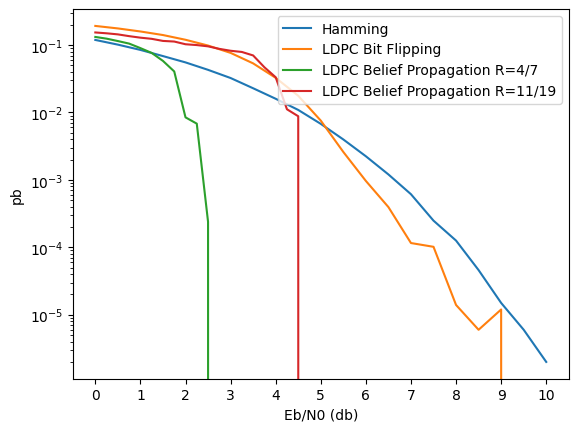

In [ ]:
snrs_db = np.arange(0, 10.5, 0.5) 
plt.plot(snrs_db, hamming_errors)
plt.plot(snrs_db, ldpc_bitflipping_errors)
plt.plot(snr_db_values_Ei, ldpc_belief_errors)
plt.plot(snr_db_values_Ei, ldpc_belief_errors_new)
plt.yscale("log")
plt.legend(["Hamming", "LDPC Bit Flipping", "LDPC Belief Propagation R=4/7", f"LDPC Belief Propagation R={dc-dv}/{dc}"], loc="upper right")
plt.xlabel("Eb/N0 (db)")
plt.ylabel("pb")
plt.xticks(np.arange(0, 11, 1))